## Import Library

In [1]:
import math
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

## Data Understanding

In [2]:
# Read Dataset
df_customer = pd.read_csv('dataset/customer.csv', delimiter=';')
df_product = pd.read_csv('dataset/product.csv', delimiter=';')
df_store = pd.read_csv('dataset/store.csv', delimiter=';')
df_transaction = pd.read_csv('dataset/transaction.csv', delimiter=';')

In [3]:
# Menampilkan 5 data teratas dari data customer
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [4]:
# Menampilkan 5 data teratas dari data product
df_product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [5]:
# Menampilkan 5 data teratas dari data store
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


In [6]:
# Menampilkan 5 data teratas dari data transaction
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [7]:
# Melakukan data cleansing
df_customer['Income'] = df_customer['Income'].replace('[,]', '.', regex=True).astype('float')
df_store['Latitude'] = df_store['Latitude'].replace('[,]', '.', regex=True).astype('float')
df_store['Longitude'] = df_store['Longitude'].replace('[,]', '.', regex=True).astype('float')

In [8]:
# Mengubah format date
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'], format="%d/%m/%Y")

In [9]:
# Merge Dataset
df_merge = pd.merge(df_transaction, df_customer, on=['CustomerID'])
df_merge = pd.merge(df_merge, df_product, on=['ProductID'])
df_merge = pd.merge(df_merge, df_store, on=['StoreID'])

In [10]:
# Menampilkan informasi attribut
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   int64         
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price_x         5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   int64         
 8   Age             5020 non-null   int64         
 9   Gender          5020 non-null   int64         
 10  Marital Status  4976 non-null   object        
 11  Income          5020 non-null   float64       
 12  Product Name    5020 non-null   object        
 13  Price_y         5020 non-null   int64         
 14  StoreName       5020 non-null   object        
 15  Grou

In [11]:
# Mengecek missing value
print('Jumlah missing value untuk setiap kolom')
df_merge.isnull().sum()

Jumlah missing value untuk setiap kolom


TransactionID      0
CustomerID         0
Date               0
ProductID          0
Price_x            0
Qty                0
TotalAmount        0
StoreID            0
Age                0
Gender             0
Marital Status    44
Income             0
Product Name       0
Price_y            0
StoreName          0
GroupStore         0
Type               0
Latitude           0
Longitude          0
dtype: int64

In [12]:
# Mengecek data duplicate
duplicate_count = df_merge.duplicated().sum()
print(f"Jumlah data duplikat secara keseluruhan: {duplicate_count}")

Jumlah data duplikat secara keseluruhan: 0


In [13]:
# Menampilkan correlation matrix
df_merge.corr(numeric_only=True)

,CustomerID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Income,Price_y,Latitude,Longitude
CustomerID,1.000000,-0.016423,-0.009755,-0.024915,0.004129,-0.025952,-0.009947,0.005783,-0.016423,0.002278,-0.003122
Price_x,-0.016423,1.000000,-0.353640,0.440632,-0.032863,0.014693,0.010705,0.001196,1.000000,-0.029008,0.018652
Qty,-0.009755,-0.353640,1.000000,0.621129,0.014365,-0.027768,-0.010542,-0.028425,-0.353640,-0.004170,0.004807
TotalAmount,-0.024915,0.440632,0.621129,1.000000,-0.010722,-0.016900,-0.008774,-0.025350,0.440632,-0.029938,0.025437
StoreID,0.004129,-0.032863,0.014365,-0.010722,1.000000,-0.003872,-0.000189,0.001613,-0.032863,0.471852,-0.094943
Age,-0.025952,0.014693,-0.027768,-0.016900,-0.003872,1.000000,-0.033183,0.486692,0.014693,0.009266,0.015951
Gender,-0.009947,0.010705,-0.010542,-0.008774,-0.000189,-0.033183,1.000000,-0.071443,0.010705,-0.006051,-0.001183
Income,0.005783,0.001196,-0.028425,-0.025350,0.001613,0.486692,-0.071443,1.000000,0.001196,0.015518,0.004385
Price_y,-0.016423,1.000000,-0.353640,0.440632,-0.032863,0.014693,0.010705,0.001196,1.000000,-0.029008,0.018652
Latitude,0.002278,-0.029008,-0.004170,-0.029938,0.471852,0.009266,-0.006051,0.015518,-0.029008,1.000000,-0.395995


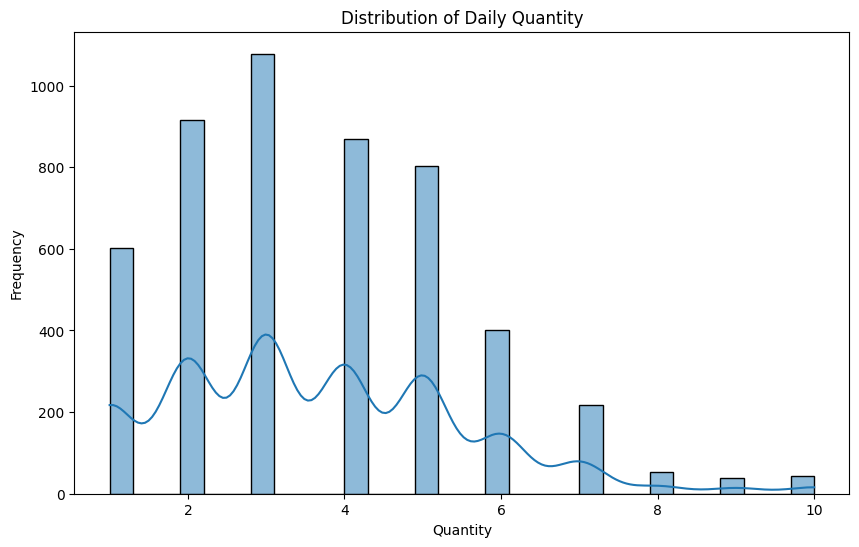

In [14]:
# Distribusi Jumlah Quantity
plt.figure(figsize=(10, 6))
sns.histplot(data=df_merge, x='Qty', bins=30, kde=True)
plt.title('Distribution of Daily Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

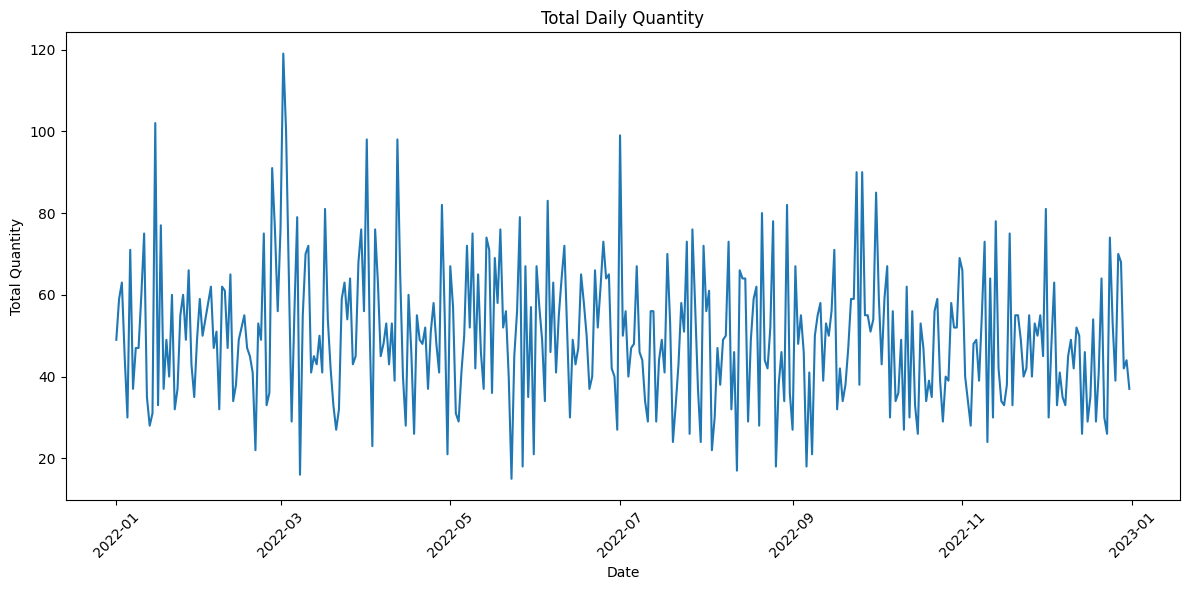

In [15]:
# Menampilkan grafik total quantity per hari
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Qty', data=df_merge.groupby('Date')['Qty'].sum().reset_index())
plt.title('Total Daily Quantity')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

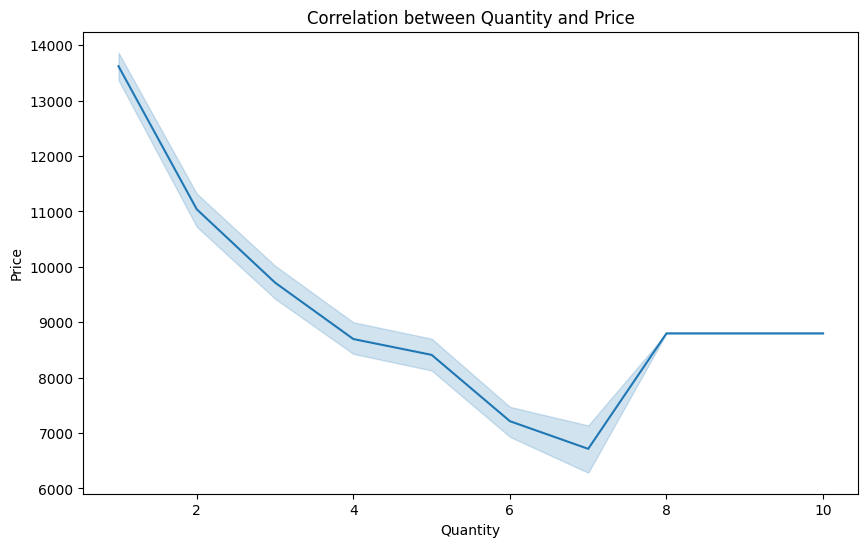

In [16]:
# Korelasi antara Quantity dengan Harga
plt.figure(figsize=(10, 6))
sns.lineplot(x='Qty', y='Price_x', data=df_merge)
plt.title('Correlation between Quantity and Price')
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.show()

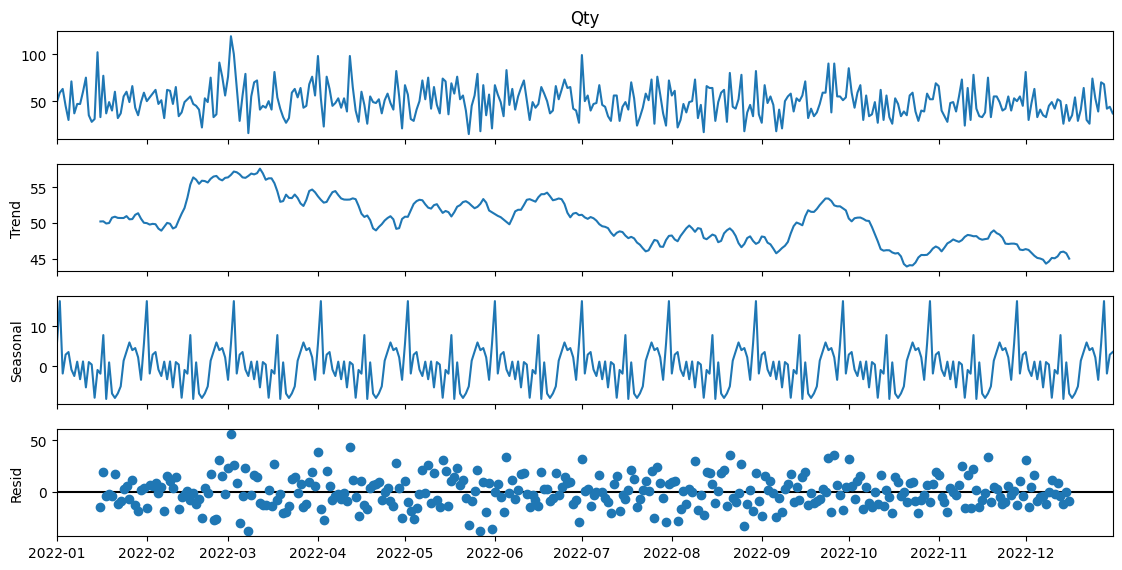

In [17]:
# Decompose Time Series
decomposition = seasonal_decompose(df_merge.groupby('Date')['Qty'].sum(), period=30)  # Misalnya, periode musiman 30 hari
fig = decomposition.plot()
fig.set_size_inches(12, 6)
plt.show()

## Data Preparation

In [18]:
# Menghilangkan missing value
df_merge = df_merge.dropna()

In [19]:
# Membuat data frame baru untuk time series
df = df_merge.groupby(['Date'])['Qty'].sum().reset_index()
df = df.set_index('Date')
df.sort_values('Date')

,Qty
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,45
2022-01-05,28
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


In [20]:
# Pisahkan data untuk pelatihan dan pengujian
train_size = int(0.7 * len(df))
train_data = df[:train_size]
test_data = df[train_size:]

## Modeling

In [21]:
# Test Augmented Dickey-Fuller untuk menguji data stasioner atau tidak
result = adfuller(df['Qty'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])        # p-value < 0.05 -> hipotesis nol diterima & deret ini dianggap stasioner => d = 0
print('Critical Values:')           
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -19.248302
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571


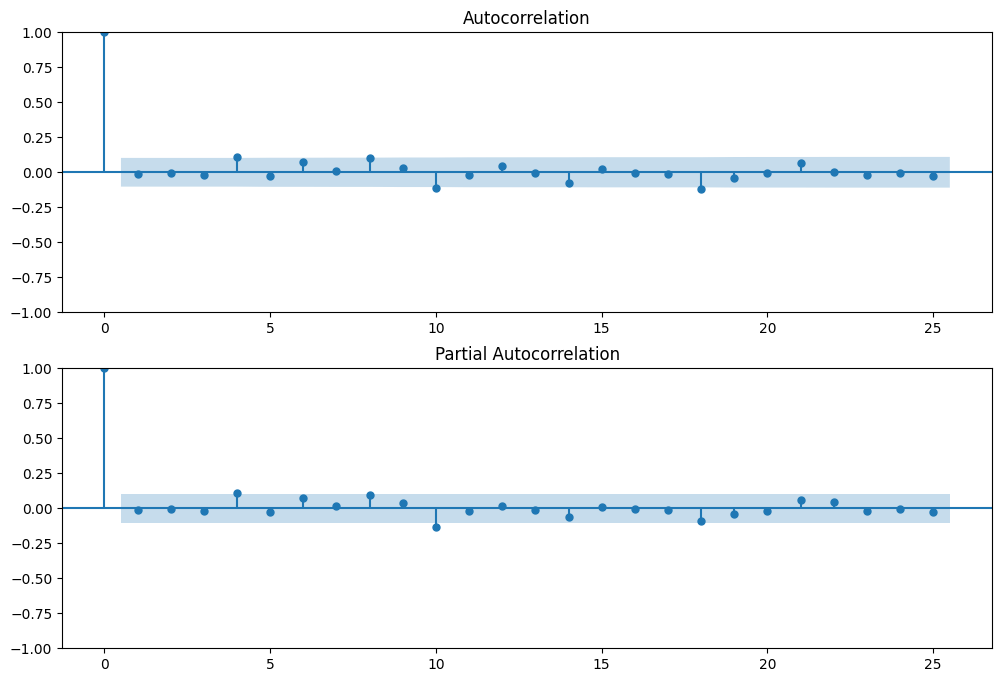

In [22]:
# Plot ACF dan PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['Qty'], lags=25, ax=ax1)
plot_pacf(df['Qty'], lags=25, ax=ax2)
plt.show()

In [23]:
# Inisialisasi model ARIMA
p, d, q = 4, 0, 4 # Ganti dengan nilai yang sesuai analisis data yang telah dilakukan
model = ARIMA(train_data, order=(p, d, q))

# Latih model SARIMAX
model = model.fit()

d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\Coding\Projects\kalbe-sales-insight\env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Evaluation

In [24]:
# Lakukan prediksi pada data test
predictions = model.get_forecast(steps=len(test_data)).predicted_mean

In [25]:
# Membulatkan angka hasil prediksi
predictions.apply(lambda x: math.floor(x))

2022-09-13    50
2022-09-14    51
2022-09-15    56
2022-09-16    56
2022-09-17    50
              ..
2022-12-27    49
2022-12-28    50
2022-12-29    50
2022-12-30    51
2022-12-31    51
Freq: D, Name: predicted_mean, Length: 110, dtype: int64

In [26]:
# Hitung Mean Squared Error
mse = mean_squared_error(test_data, predictions)

# Tampilkan hasil MSE
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 225.13830932424676


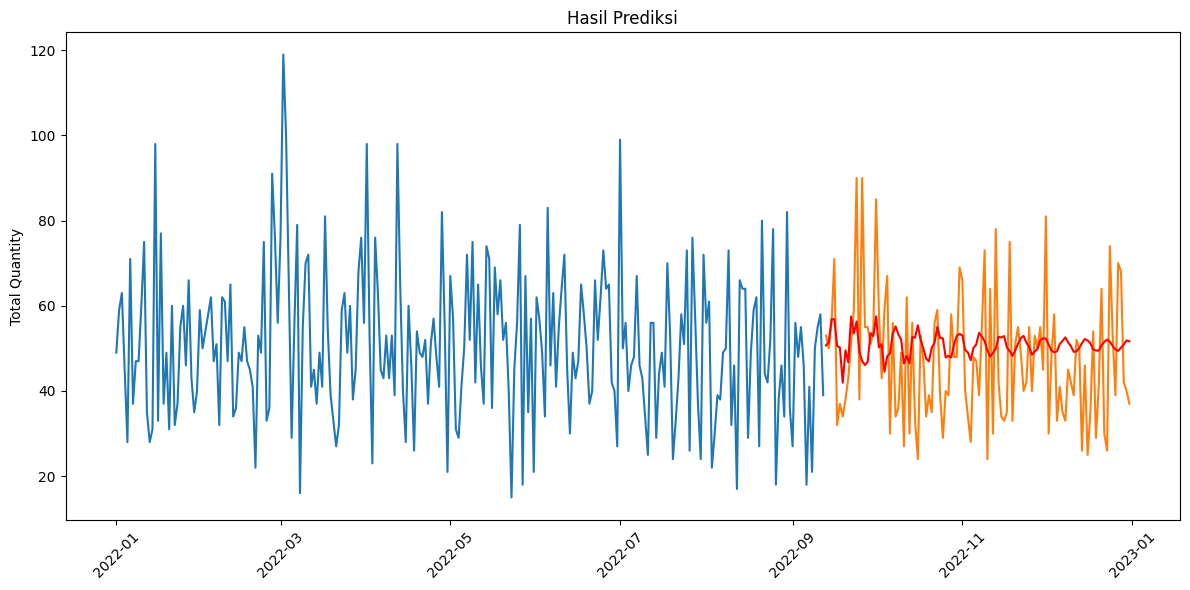

In [27]:
# Menampilkan grafik hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(train_data['Qty'])
plt.plot(test_data['Qty'])
plt.plot(predictions, color='red')
plt.title('Hasil Prediksi')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()